In [14]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
print(tf.__version__)

def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def create_submission(test_directory, save= True, preprocess_function= None, family= "generic", name= "model"):
    if preprocess_function is not None:
        tDatagen = ImageDataGenerator(
            preprocessing_function=preprocess_function
        )
    else:
        tDatagen = ImageDataGenerator(rescale=1./255.)
    test_datagen = tDatagen.flow_from_directory(
        test_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False #To mantain order and being able to metric
    )
    preds = model.predict(test_datagen)
    filenames = [os.path.basename(f) for f in test_datagen.filenames]  
    pred_indices = np.argmax(preds, axis=1)
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    pred_classes = [class_labels[i] for i in pred_indices]
    submissions = pd.DataFrame({
        "id": filenames,
        "category": pred_classes
    })
    submissions.set_index('id',inplace=True)
    os.makedirs("submissions", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
    submission_path = f"submissions/{family}_{name}_{timestamp}.csv"
    if save:
        submissions.to_csv(submission_path)
    return submissions

2.18.0


### Under and Oversampling

In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def get_class_weights(generator):
    """
    Compute class weights for imbalanced datasets when using flow_from_directory.
    
    Args:
        generator: Keras ImageDataGenerator.flow_from_directory object (train_generator)
    
    Returns:
        dict mapping class index -> weight
    """
    class_indices = generator.class_indices
    classes = np.unique(generator.classes)
    
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=generator.classes
    )
    
    return dict(zip(classes, class_weights))

### Hiperparameters

In [3]:
target_size = (250, 250)
batch_size = 128
data_dir = '/kaggle/input/animalprediction/mg-animal-prediction-25-26/train_images'

## For model save
family = "Transfer"
name = "main"
model_path = None

### Model

In [4]:
vgg16 = VGG16(weights='imagenet',include_top = False, input_shape=(target_size[0], target_size[1], 3))

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))
for layer in vgg16.layers[:13]:
    layer.trainable = False
print(model.summary())

I0000 00:00:1759254476.766479      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,725,770 (105.77 MB)

 Trainable params: 22,450,314 (85.64 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

None


In [5]:
# We create a generator to enrich data
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% for validation
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=2004
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=2004
)

Found 16947 images belonging to 10 classes.
Found 4232 images belonging to 10 classes.


In [6]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(get_class_weights(train_generator))

{0: 0.48544829561730163, 1: 0.9974690994702766, 2: 2.2387054161162485, 3: 1.313720930232558, 4: 0.8151515151515152, 5: 1.8125133689839572, 6: 1.5505032021957914, 7: 1.6048295454545454, 8: 0.49022273647671394, 9: 1.5547706422018348}


In [7]:
history = model.fit(
train_generator,
epochs = 20,
validation_data = validation_generator,
verbose = 1,
class_weight=get_class_weights(train_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1759254502.892820      92 service.cc:148] XLA service 0x7832a8006010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759254502.893803      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759254503.497247      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-30 17:48:32.748963: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,250,250]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,250,250]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-3

133/133 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.3247 - loss: 2.4063 - val_accuracy: 0.7802 - val_loss: 0.6535
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.7985 - loss: 0.6243 - val_accuracy: 0.8495 - val_loss: 0.4728
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8695 - loss: 0.4166 - val_accuracy: 0.8845 - val_loss: 0.3712
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8946 - loss: 0.3251 - val_accuracy: 0.9116 - val_loss: 0.2717
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9125 - loss: 0.2888 - val_accuracy: 0.9116 - val_loss: 0.2842
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9247 - loss: 0.2403 - val_accuracy: 0.9291 - val_loss: 0.2405
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9315 - loss: 0.2034 - val_accuracy: 0.9223 - val_loss: 0.2532
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9372 - loss: 0.2013 - val_accuracy: 0.923

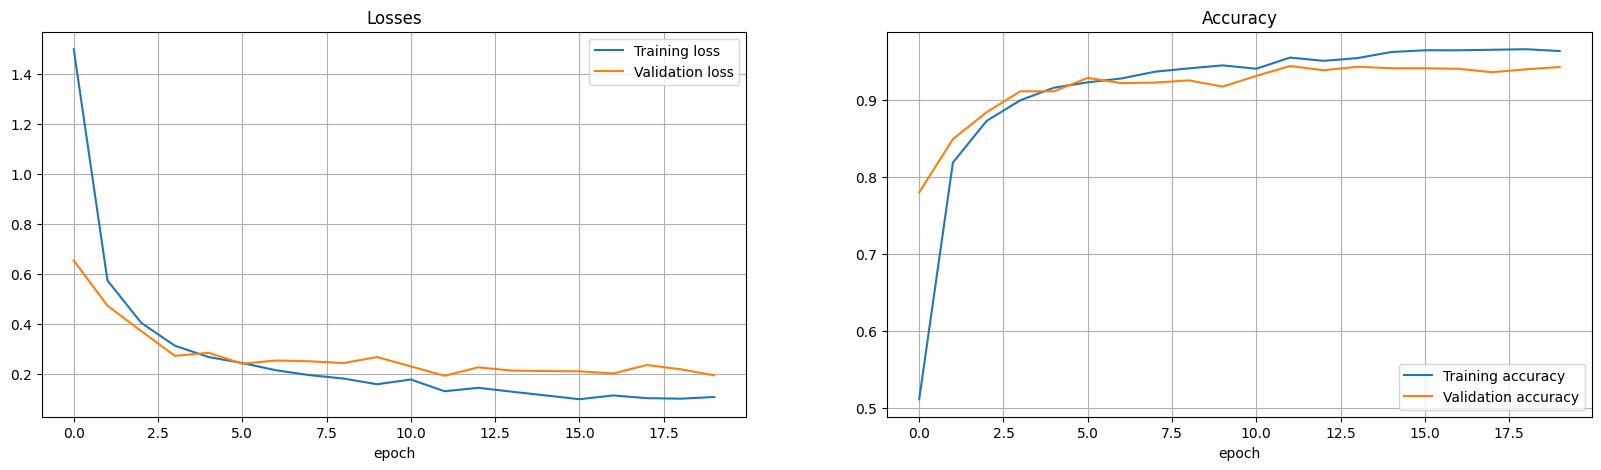

In [8]:
plot_losses(history.history)

In [12]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
try:
    family = family
except:
    family= "Transfer"
try:
    name = name
except:
    name= "main"
model_path = f"models/{family}_{name}_{timestamp}.keras"

# Save the model
model.save(model_path)

In [15]:
create_submission("/kaggle/input/animalprediction/mg-animal-prediction-25-26/test_images", preprocess_function= preprocess_input, family=family, name=name)

Found 5000 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step


,category
id,
0.jpeg,scoiattolo
1.jpeg,cavallo
10.jpeg,scoiattolo
100.jpeg,pecora
1000.jpeg,cavallo
...,...
995.jpeg,cavallo
996.jpeg,pecora
997.jpeg,cane
